# GDS geometries and MEEP

## 2D

Some imports and parameters as usual :

In [3]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt
import ipyvolume as ipv

In [4]:
oxide=mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

res = 32        # pixels/μm

Last week you were introduced to zeropdk, a way to create GDS masks. You can directly upload your GDS masks into MEEP for simulation! You just need to add dummy layers to define your simulation ports. It is as easy as calling `mp.get_GDSII_prisms` with a material, GDS file, and layer number (figure from https://meep.readthedocs.io/en/latest/Python_Tutorials/GDSII_Import/) :

!['gds_coupler'](https://meep.readthedocs.io/en/latest/images/klayout_schematic.png)

In [5]:
gdsII_file = 'coupler.gds'

CELL_LAYER = 0
UPPER_BRANCH_LAYER = 31
LOWER_BRANCH_LAYER = 32 # They have two layers of silicon here to parametrize the distance between the branches at this level

upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER)
lower_branch = mp.get_GDSII_prisms(silicon, gdsII_file, LOWER_BRANCH_LAYER)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, zmin=0, zmax=0) # for 2D simulation, don't care about zmin and zmax

Dummy layers can also be included to precisely denote the positions of the input port for the simulation :

In [6]:
SOURCE_LAYER = 5

src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, zmin=0, zmax=0)

In [ ]:
sim.init_sim

Then repeat simulation definition as before :

In [10]:
dpml = 1

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen

geometry = upper_branch+lower_branch

sources = [mp.EigenModeSource(src=mp.ContinuousSource(fcen,fwidth=df),
                              size=src_vol.size,
                              center=src_vol.center,
                              eig_band=1,
                              eig_parity=mp.EVEN_Y+mp.ODD_Z,
                              eig_match_freq=True)]

sim = mp.Simulation(resolution=res,
                    cell_size=cell.size,
                    boundary_layers=[mp.PML(dpml)],
                    sources=sources,
                    geometry=geometry)

In [11]:
sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000305891 s
Working in 2D dimensions.
Computational cell is 34.4062 x 8 x 0 with resolution 32
     prism, center = (-9.09425,1.41149,0)
          height 0, axis (0,0,1), 174 vertices:
          (-4,0.15,0)
          (-4.108,0.151,0)
          (-4.215,0.152,0)
          (-4.322,0.155,0)
          (-4.429,0.16,0)
          (-4.535,0.165,0)
          (-4.641,0.171,0)
          (-4.747,0.179,0)
          (-4.852,0.187,0)
          (-5.062,0.207,0)
          (-5.167,0.219,0)
          (-5.271,0.231,0)
          (-5.479,0.259,0)
          (-5.582,0.274,0)
          (-5.685,0.29,0)
          (-5.788,0.307,0)
          (-5.891,0.325,0)
          (-5.993,0.343,0)
          (-6.095,0.362,0)
          (-6.197,0.382,0)
          (-6.299,0.403,0)
          (-6.4,0.424,0)
          (-6.501,0.446,0)
          (-6.703,0.492,0)
          (-6.803,0.515,0)
          (-6.904,0.54,0)
          (-7.204,0.615,0)
          (-7.303,0.642,

Look at the geometry before simulating :

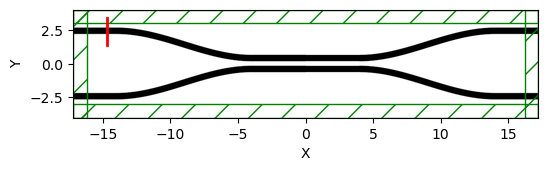

In [9]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Simulate for the fields :

In [ ]:
sim.run(until=400)  # arbitrary long run time to ensure that fields have reached steady state

Meep progress: 15.015625/400.0 = 3.8% done in 4.0s, 102.6s to go
on time step 961 (time=15.0156), 0.00416328 s/step
Meep progress: 29.921875/400.0 = 7.5% done in 8.0s, 99.0s to go
on time step 1916 (time=29.9375), 0.00418923 s/step
Meep progress: 45.8125/400.0 = 11.5% done in 12.0s, 92.8s to go
on time step 2933 (time=45.8281), 0.00393317 s/step
Meep progress: 63.0625/400.0 = 15.8% done in 16.0s, 85.5s to go
on time step 4039 (time=63.1094), 0.00361791 s/step
Meep progress: 85.203125/400.0 = 21.3% done in 20.0s, 73.9s to go
on time step 5456 (time=85.25), 0.00282459 s/step
Meep progress: 101.0625/400.0 = 25.3% done in 24.0s, 71.0s to go
on time step 6472 (time=101.125), 0.00393875 s/step
Meep progress: 117.015625/400.0 = 29.3% done in 28.0s, 67.7s to go
on time step 7494 (time=117.094), 0.00391611 s/step
Meep progress: 132.984375/400.0 = 33.2% done in 32.0s, 64.3s to go
on time step 8516 (time=133.062), 0.00391495 s/step
Meep progress: 148.9375/400.0 = 37.2% done in 36.0s, 60.7s to go


Plot the result :

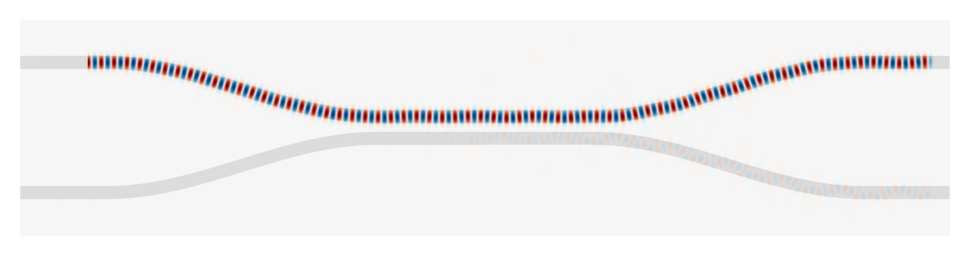

In [8]:
eps_data = sim.get_epsilon()
ez_data = np.real(sim.get_efield_z())

plt.figure(dpi=200)
plt.imshow(np.transpose(eps_data), interpolation='spline36', cmap='binary')
plt.imshow(np.flipud(np.transpose(ez_data)), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

Note : this is expected. Coupling depends on wavelength, distance, etc.

!['coupler'](https://meep.readthedocs.io/en/latest/images/directional_coupler_field_profiles.png)

## Extruding to 3D

We can also give a $z_{min}$ and $z_{max}$ argument to the layers when we load them for 3D simulations.

In [9]:
sim.reset_meep()

t_oxide = 1.0
t_Si = 0.22
t_air = 0.78

cell_thickness = dpml+t_oxide+t_Si+t_air+dpml
si_zmin = 0

cell_zmax = 0.5*cell_thickness
cell_zmin = -0.5*cell_thickness
si_zmax = t_Si

In [10]:
upper_branch = mp.get_GDSII_prisms(silicon, gdsII_file, UPPER_BRANCH_LAYER, si_zmin, si_zmax)
lower_branch = mp.get_GDSII_prisms(silicon, gdsII_file, LOWER_BRANCH_LAYER, si_zmin, si_zmax)
geometry = upper_branch+lower_branch

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)

oxide_center = mp.Vector3(z=-0.5*t_oxide)
oxide_size = mp.Vector3(cell.size.x,cell.size.y,t_oxide)
oxide_layer = [mp.Block(material=oxide, center=oxide_center, size=oxide_size)]
geometry = geometry+oxide_layer

# Uncomment this to setup the simulations. Takes a while to run!

#sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
#                              size=src_vol.size,
#                              center=src_vol.center,
#                              eig_band=1,
#                              eig_parity=mp.NO_PARITY,
#                              eig_match_freq=True)]

# Display simulation object
#sim = mp.Simulation(resolution=res,
#                    eps_averaging=False,
#                    subpixel_maxeval=1,
#                    subpixel_tol=1,
#                    cell_size=cell.size,
#                    boundary_layers=[mp.PML(dpml)],
#                    sources=sources,
#                    geometry=geometry)

Usually (say on your own machine), you can use Mayavi to easily visualize in 3D with `sim.plot3D`. It doesn't work well on the cluster, so I made a workaround :

In [11]:
def unpack_geometry(geometry, wavelength=1.55, indices = [0,0]):
    """
    returns a 3D numpy array of permittivities vs position for plotting
    Args:
        geometry : a MEEP geometry object
        wavelength : the wavelength at which to report permittivity (in microns)
        indices : the indices of the permittivity tensor to report
    """
    # Read the geometry object
    V = []
    if isinstance(geometry, list):
        for element in geometry:
            eps = element.material.epsilon(wavelength)[indices[0],indices[1]]
            for vertex in element.vertices:
                V.append([vertex.x, vertex.y, vertex.z])
    else:
        eps = geometry.material.epsilon(wavelength)[indices[0],indices[1]]
        for vertex in geometry.vertices:
            V.append([vertex.x, vertex.y, vertex.z])
                
    return V

In [1]:
# Uncomment this to generate the datafile for 3D viewing

#sim.init_sim()
#data = unpack_geometry(geometry, wavelength=1.55, indices = [0,0])
#np.save(data, 'coupler_eps.npy')

In [13]:
data = np.load('coupler_eps.npy')

In [14]:
np.shape(data)

(1720, 391, 200)

In [15]:
ipv.quickvolshow(data)

/home/ELE559/anaconda3/envs/mp/lib/python3.7/site-packages/ipyvolume/widgets.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/home/ELE559/anaconda3/envs/mp/lib/python3.7/site-packages/ipyvolume/utils.py:204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2])/2
/home/ELE559/anaconda3/envs/mp/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2